In [112]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from IPython.display import clear_output

In [113]:
def read_kImage(path):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(path)
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    return ct_scan

In [114]:
def extract_voxel_data(series_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( series_path )
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image_3d = sitk.GetArrayFromImage(image)
    return image_3d

In [115]:
def normalize_image(image_3D):
    z,y,x = image_3D.shape
    new_image_3D = np.empty(shape = (z,y,x) )
    target_min = -1
    target_max = 1
    for i in range (z):
        max_value = np.max (image_3D[i])
        min_value = np.min (image_3D[i])
        new_image_3D[i] = (image_3D[i] - min_value)*(float(target_max - target_min)/(max_value - min_value)) + target_min
    return new_image_3D

In [116]:
def subvoxel (img_3d,ijk, window):
    ijk = ijk.split()
    x = int(ijk[0])
    y = int(ijk[1])
    z = int(ijk[2])
    if (z < 0):
        z = z*(-1)
    new_img3d = np.empty(shape = (3,img_3d.shape[1], img_3d.shape[2]))
    max_bandwith = img_3d.shape[0] - 1
    if ( z == max_bandwith ):
        new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
        new_img3d[1,:,:] = img_3d[z,:,:] #n
        new_img3d[2,:,:] = img_3d[z,:,:] #n
    else:
        if (z == 0):
            new_img3d[0,:,:] = img_3d[z,:,:] #0
            new_img3d[1,:,:] = img_3d[z,:,:] #0
            new_img3d[2,:,:] = img_3d[z+1,:,:] #1
        else:
            new_img3d[0,:,:] = img_3d[z-1,:,:] #n-1
            new_img3d[1,:,:] = img_3d[z,:,:] #n
            new_img3d[2,:,:] = img_3d[z+1,:,:] #n+1
    window = window//2
    new_img3d = new_img3d[:, y-window : y+window, x-window : x+window]
    return new_img3d

In [117]:
def generate_training_dataframes():
    basedir = "../1/train/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Train.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Train.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Train.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    #agregamos una columna para los parches
    #agregamos otra columna para la integridad de los datos
    #agregamos otra columna para las predicciones
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_images_table["InterestSequence"] = pd.Series(False, index= join_images_table.index)
    join_images_table["Predictions"] = pd.Series(0, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    join_kimages_table["Predictions"] = pd.Series(0, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [118]:
def generate_testing_dataframes():
    basedir = "../1/test/ProstateX-TestLesionInformation/ProstateX-TestLesionInformation"
    findingsfile = "{}/{}".format(basedir,"ProstateX-Findings-Test.csv")
    imagesfile = "{}/{}".format(basedir,"ProstateX-Images-Test.csv")
    kimagesfile = "{}/{}".format(basedir,"ProstateX-Images-KTrans-Test.csv")
    #Generamos las 3 tablas básicas a partir de los archivos.cvs
    findings_table = pd.read_csv(findingsfile)
    images_table = pd.read_csv(imagesfile)
    kimages_table = pd.read_csv(kimagesfile)
    #Operación de inner join entre tablas.
    join_kimages_table = pd.merge(left=findings_table, right= kimages_table, how ="inner", on=["ProxID","fid"])
    join_images_table =  pd.merge(left=findings_table, right=  images_table, how ="inner", on=["ProxID","fid"])
    #agregamos una columna para insertar la imagen
    join_images_table["MRI3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["MRIPatch3D"] = pd.Series(np.zeros((len(join_images_table),2,2,2)).tolist(), index= join_images_table.index)
    join_images_table["State"] = pd.Series(False, index= join_images_table.index)
    join_images_table["InterestSequence"] = pd.Series(False, index= join_images_table.index)
    join_kimages_table["Kimg3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["KimgPatch3D"] = pd.Series(np.zeros((len(join_kimages_table),2,2,2)).tolist(), index= join_kimages_table.index)
    join_kimages_table["State"] = pd.Series(False, index= join_kimages_table.index)
    return join_images_table, join_kimages_table

In [119]:
def isValid_data(img_3d, ijk):
    state = False
    k_string = ijk.split()[2]
    max_bandwith = img_3d.shape[0] -1
    possible_k = int (k_string)
    if (possible_k >= max_bandwith):
        possible_k = max_bandwith
        slice_index = possible_k
        state = True
        print("The ijk requested is [{}], there was an error since the shapes of the image is {}".format(ijk,str(img_3d.shape)))
    else:
        if possible_k >= 0:
            slice_index = possible_k
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
        else:
            state = False
            print("The ijk requested is [{}],OK since shapes of the image is {}".format(ijk,str(img_3d.shape)))
    return state

In [120]:
def set_MRI_value(dataFrame,index,image3d,state,window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"MRI3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"MRIPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"MRIPatch3D"] = np.zeros(shape= (window,image3d.shape[0],image3d.shape[1]))
    

In [121]:
def set_kImg_value(dataFrame,index,image3d,state, window):
    row = dataFrame.iloc[index]
    dataFrame.at[index,"Kimg3D"] = image3d
    dataFrame.at[index,"State"] = state
    if state == False:
        dataFrame.at[index,"KimgPatch3D"] = subvoxel(img_3d=image3d, ijk=row.ijk, window=window)
    else:
        dataFrame.at[index,"KimgPatch3D"] = np.empty(shape= image3d.shape)
    

In [122]:
def fill_ktrans_images_dataframe_at_training(dataFrame, window):
    if window == None:
        window = 40
    for row in range(len(dataFrame)):
        path = "../1/train/ProstateXKtrains-train-fixed"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state,window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [123]:
def fill_ktrans_images_dataframe_at_testing(dataFrame, window):
    for row in range(len(dataFrame)):
        path = "../1/test/ProstateXKtrans-test-fixedv2/ProstateXKtrans-test-fixedv2"
        patient_id = dataFrame.ProxID.iloc[row]
        ijk = dataFrame.ijk.iloc[row]
        path = "{}/{}".format(path,patient_id)
        path = "{}/{}-Ktrans.mhd".format(path,patient_id)
        kimage_3d = read_kImage(path)
        kimage_3d = normalize_image(kimage_3d)
        state =  isValid_data(kimage_3d,ijk)
        set_kImg_value(dataFrame,row,kimage_3d,state, window)
        print("Se ha cargado la k-trans imagen3d #{} para el paciente {} ".format(row,patient_id))
        del path,patient_id,kimage_3d,state


In [48]:
training_MRI_imgs_dataframe, training_ktrans_imgs_dataframe = generate_training_dataframes()
#testing_MRI_imgs_dataframe, testing_ktrans_imgs_dataframe = generate_testing_dataframes()

In [124]:
window = 40
#fill_ktrans_images_dataframe_at_training(dataFrame = training_ktrans_imgs_dataframe , window =window)
#fill_ktrans_images_dataframe_at_testing(dataFrame = testing_ktrans_imgs_dataframe, window = window)
clear_output()
print ("All the Ktrans training images were read correctly")
print ("All the Ktrans testing images were read correctly")
training_ktrans_imgs_dataframe = training_ktrans_imgs_dataframe[ training_ktrans_imgs_dataframe.State == False]
training_ktrans_imgs_dataframe.reset_index(drop=True)
training_ktrans_imgs_dataframe.index = pd.RangeIndex(len(training_ktrans_imgs_dataframe))
display(training_ktrans_imgs_dataframe[["ProxID", "fid", "ijk", "ClinSig"]].iloc[35:60])

All the Ktrans training images were read correctly
All the Ktrans testing images were read correctly


,ProxID,fid,ijk,ClinSig
35,ProstateX-0025,1,67 88 -7,False
36,ProstateX-0025,1,75 79 7,False
37,ProstateX-0025,1,81 77 7,False
38,ProstateX-0025,1,89 67 24,False
39,ProstateX-0025,1,67 88 -7,False
40,ProstateX-0025,1,75 79 7,False
41,ProstateX-0025,1,81 77 7,False
42,ProstateX-0025,1,89 67 24,False
43,ProstateX-0025,2,57 89 -7,False
44,ProstateX-0025,2,71 79 7,False


In [125]:
def fill_MRI_images_dataframe_at_training(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        path = "../1/train/PROSTATEx/{}/".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        #sequence = [ sequence for sequence in sequences if sequence[0:len(str(series_id))] == str(series_id) ] [0]
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [126]:
def fill_MRI_images_dataframe_at_testing(dataFrame, window):
    for row in range (len(dataFrame)):
        print("===============================================================")
        patient_id = dataFrame.ProxID.iloc[row]
        series_name = dataFrame.DCMSerDescr.iloc[row]
        sequence_name = dataFrame.Name.iloc[row]
        series_id = dataFrame.DCMSerNum.iloc[row]
        slice_ijk = dataFrame.ijk.iloc[row]
        path = "../1/test/PROSTATEx/{}".format(patient_id)#Selects the Patient ID
        path = "{}/{}".format(path,os.listdir(path)[0])#Selects the default folder inside the patient
        sequences = os.listdir(path) # Selects all the sequences
        for sequence in sequences:
            sequence_id = sequence[0:len(str(series_id))]
            if (str(sequence_id) == str(series_id)):
                print ("The condition is true {} = {}".format(sequence_id,series_id))
                print ("The sequence selected is {}".format(sequence))
                print ("The requested sequence is {}".format(sequence_name))
                break
        # Selects the only sequence that matches the condition.
        path = "{}/{}".format(path,sequence)
        image_3d = extract_voxel_data(path)
        state = isValid_data(ijk=slice_ijk, img_3d=image_3d)
        set_MRI_value(dataFrame,row,image_3d,state,40)
        print("Se ha cargado la imagen MRI3D y MRI3DPATCH #{} para el paciente {} serie: {} ".format(row,patient_id,series_name))
        del path, patient_id, series_name, series_id,sequence,sequences, image_3d

In [127]:
fill_MRI_images_dataframe_at_training(dataFrame = training_MRI_imgs_dataframe, window = window)
#fill_MRI_images_dataframe_at_testing(dataFrame = testing_MRI_imgs_dataframe, window = window)
clear_output()
print ("All the MRI training images were read correctly")
print ("All the MRI testing images were read correctly")
training_MRI_imgs_dataframe =training_MRI_imgs_dataframe[ training_MRI_imgs_dataframe.State == False]
training_MRI_imgs_dataframe.reset_index(drop=True)
training_MRI_imgs_dataframe.index = pd.RangeIndex(len(training_MRI_imgs_dataframe))
display(training_MRI_imgs_dataframe[["ProxID", "fid", "ijk", "ClinSig"]].iloc[35:60])


All the MRI training images were read correctly
All the MRI testing images were read correctly


,ProxID,fid,ijk,ClinSig
35,ProstateX-0002,2,45 70 9,False
36,ProstateX-0002,2,134 137 1,False
37,ProstateX-0002,2,153 151 0,False
38,ProstateX-0002,2,170 186 12,False
39,ProstateX-0002,2,178 169 8,False
40,ProstateX-0002,2,203 216 10,False
41,ProstateX-0002,2,68 72 8,False
42,ProstateX-0003,1,54 68 11,False
43,ProstateX-0003,1,54 68 11,False
44,ProstateX-0003,1,54 68 11,False


In [128]:
def setup_MRI_series_descriptions():
    for i in range (len(training_MRI_imgs_dataframe)):
        DCM_description = str.lower( training_MRI_imgs_dataframe.DCMSerDescr.iloc[i] )
        DCM_description = DCM_description.replace(" ","_")
        DCM_description = DCM_description.replace("-","_")
        training_MRI_imgs_dataframe.at[i,"DCMSerDescr"] = DCM_description
    print(training_MRI_imgs_dataframe.DCMSerDescr.unique())
setup_MRI_series_descriptions()

['ep2d_diff_tra_dyndist_adc' 'ep2d_diff_tra_dyndist'
 'ep2d_diff_tra_dyndistcalc_bval' 't2_tse_cor' 't2_tse_sag' 't2_tse_tra'
 'tfl_3d_pd_ref_tra_1.5x1.5_t3' 'ep2d_diff_tra_dyndist_mix_adc'
 'ep2d_diff_tra_dyndist_mix' 'ep2d_diff_tra_dyndist_mixcalc_bval'
 't2_localizer' 't2_loc_sag' 't2_tse_tra_exacte_copy_diffusie'
 't2_loc_tra' 'adc_s3_1' 'adc_s3_2'
 'ep2d_diff_tra2x2_noise0_fs_dyndist_adc'
 'ep2d_diff_tra2x2_noise0_fs_dyndist'
 'ep2d_diff_tra2x2_noise0_fs_dyndistcalc_bval'
 'ep2d_diff_tra2x2_noise0_nofs_dyndist_adc'
 'ep2d_diff_tra2x2_noise0_nofs_dyndist'
 'ep2d_diff_tra2x2_noise0_nofs_dyndistcalc_bval'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=10.2s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=100.5s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=101.7s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=103.0s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=104.2s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=105.5s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=106.8s'
 'perfusie_t1_twist_1.3x1.3x3_temp_2s_tt=10

In [129]:
#find substrings
def return_MRI_serie_of_interest(serie_of_interest):
    for i in range (len( training_MRI_imgs_dataframe )):
        training_MRI_imgs_dataframe.at[i,"InterestSequence"] = False
        if (training_MRI_imgs_dataframe.DCMSerDescr.iloc[i].find(serie_of_interest) != -1):
            training_MRI_imgs_dataframe.at[i,"InterestSequence"] = True

    dataframe = training_MRI_imgs_dataframe[ training_MRI_imgs_dataframe.InterestSequence == True ]
    return dataframe

In [130]:
#DWI-ADC
serie_of_interest = "dyndist_adc"
dyndist_adc_dataframe = return_MRI_serie_of_interest(serie_of_interest)
dyndist_adc_dataframe.reset_index(drop=True)
dyndist_adc_dataframe.index = pd.RangeIndex(len(dyndist_adc_dataframe))

#t2_tse_cor
serie_of_interest = "t2_tse_cor"
t2_tse_cor_dataframe = return_MRI_serie_of_interest(serie_of_interest)
t2_tse_cor_dataframe.reset_index(drop=True)
t2_tse_cor_dataframe.index = pd.RangeIndex(len(t2_tse_cor_dataframe))

#t2_tse_sag
serie_of_interest = "t2_tse_sag"
t2_tse_sag_dataframe = return_MRI_serie_of_interest(serie_of_interest)
t2_tse_sag_dataframe.reset_index(drop=True)
t2_tse_sag_dataframe.index = pd.RangeIndex(len(t2_tse_sag_dataframe))

#t2_tse_tra
serie_of_interest = "t2_tse_tra"
t2_tse_tra_dataframe = return_MRI_serie_of_interest(serie_of_interest)
t2_tse_tra_dataframe.reset_index(drop=True)
t2_tse_tra_dataframe.index = pd.RangeIndex(len(t2_tse_tra_dataframe))


In [131]:

def get_dataframe_given_zone(zone, dataFrame):
    dataFrame = dataFrame[dataFrame.zone == zone]
    return dataFrame

In [133]:
def get_data_labels (dataFrame):
    indexes = dataFrame.index
    data = dataFrame.MRIPatch3D
    labels = dataFrame.ClinSig
    z,y,x = [3,40,40]
    all_data = np.empty(shape= (len(data), z*y*x ) )
    all_labels = np.zeros(shape= (len(data) ) )
    i = 0
    for index in indexes:
        all_data[i,:] = data[index].reshape((1,x*y*z))
        label = labels [index]
        all_labels[i] = label
        i = i + 1
    return all_data, all_labels

In [134]:
def apply_Kfold_cross_validation(data, labels, classifier, kfolds):
    from sklearn.model_selection import cross_val_score
    #data, labels = get_data_labels(dataframe)

    scores = cross_val_score(classifier, data, labels, cv= kfolds)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores, scores.mean()*100, scores.std()*100

In [135]:

def create_training_file(dataframe, FileName):
    FileName = FileName +".txt"
    data, labels = get_data_labels (dataframe)
    number_of_samples, number_of_features = data.shape
    with open(FileName, "w") as text_file:
        str_line = ""
        for i in range (number_of_samples):

            str_line = "{} ".format(str(int(labels[i])))
            for j in range (number_of_features):
                str_line = "{} {}:{}".format(str_line, (j+1) , data[i,j])

            
            text_file.write(str_line)
            if (i != len(data)):
                text_file.write("\n")
            str_line = ""
        text_file.close()
    print("The file {} was succesfully created".format(FileName))

In [137]:
def plot_ROC_curve(classifier, data_test, labels_test):
    from sklearn import metrics
    probs = classifier.predict_proba(data_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(labels_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [138]:
def plot_precision_recall_curve(classifier, data_test, labels_test):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    from sklearn.metrics import average_precision_score
    from matplotlib import pyplot
    
    N = len(labels_test[labels_test==0])
    P = len(labels_test[labels_test==1])
    
    presicion_expected = P / (P + N)
    # predict probabilities
    probs = classifier.predict_proba(data_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # predict class values
    yhat = classifier.predict(data_test)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(labels_test, probs)
    # calculate F1 score
    f1 = f1_score(labels_test, yhat)
    # calculate precision-recall AUC
    auc = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(labels_test, probs)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
    
    # plot no skill
    plt.figure(figsize=(10,10))
    plt.title("Precision Recall Curve (P:N  {}:{})".format(P,N))
    plt.plot([0, 1], [presicion_expected, presicion_expected],'r--')
    # plot the roc curve for the model
    plt.plot(recall, precision, 'b')
    plt.ylabel('Precision')
    plt.xlabel("Recall")
    plt.show()

# DWI-ADC Images experiment

In [149]:
dyndist_adc_dataframe_at_PZ = get_dataframe_given_zone("PZ", dyndist_adc_dataframe)
dyndist_adc_dataframe_at_AS = get_dataframe_given_zone("AS", dyndist_adc_dataframe)
dyndist_adc_dataframe_at_TZ  = get_dataframe_given_zone("TZ", dyndist_adc_dataframe)
dyndist_adc_dataframe_at_SV = get_dataframe_given_zone("SV", dyndist_adc_dataframe)

In [155]:

create_file = True

if(create_file == True):
    print("We are creating the datasets needed.")
    dataframe = dyndist_adc_dataframe_at_PZ
    FileName= "dyndist_adc_dataframe_at_PZ"
    create_training_file(dataframe,FileName)

    dataframe = dyndist_adc_dataframe_at_AS
    FileName= "dyndist_adc_dataframe_at_AS"
    create_training_file(dataframe,FileName)

    dataframe = dyndist_adc_dataframe_at_TZ
    FileName= "dyndist_adc_dataframe_at_TZ"
    create_training_file(dataframe,FileName)

    dataframe = dyndist_adc_dataframe
    FileName = "dyndist_adc_dataframe"
    create_training_file(dataframe,FileName)
else:
    print("No dataset will be created.")

We are creating the datasets needed.
The file dyndist_adc_dataframe_at_PZ.txt was succesfully created
The file dyndist_adc_dataframe_at_AS.txt was succesfully created
The file dyndist_adc_dataframe_at_TZ.txt was succesfully created
The file dyndist_adc_dataframee.txt was succesfully created


This is an experimnent with the DWI-ADC images
Random Forest 20
PZ zone.
The TP value is: 0.1717171717171717
[0.78571429 0.84615385 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333]
Accuracy: 0.83 (+/- 0.03)


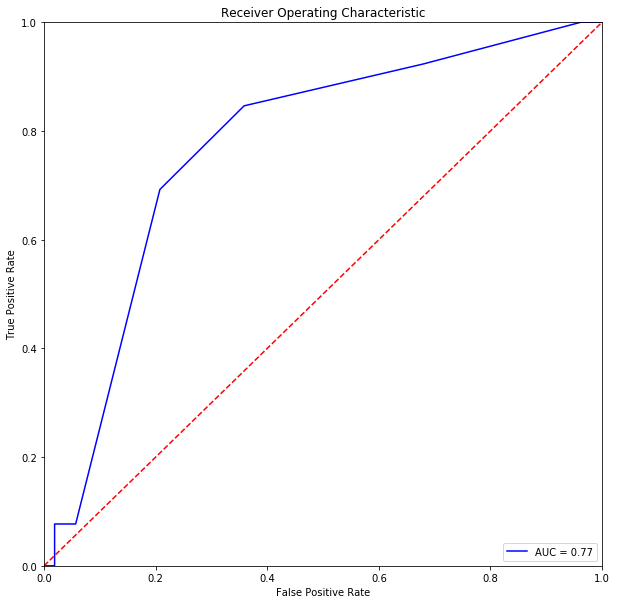

f1=0.000 auc=0.363 ap=0.392


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


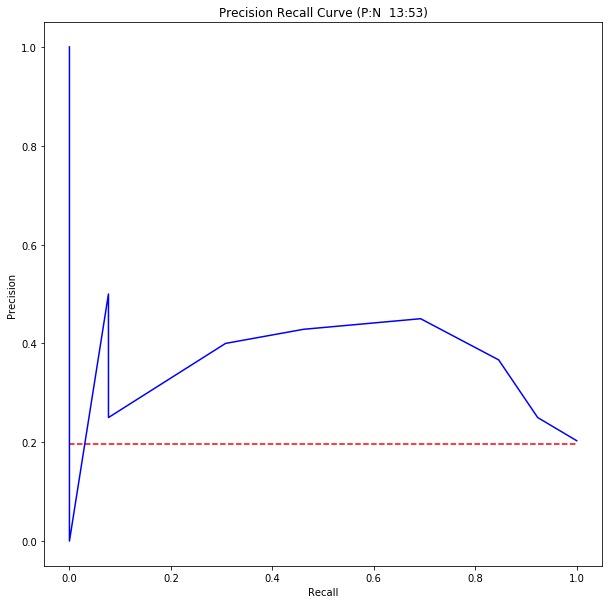

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


The result with the testing data is: 0.803030303030303
TZ zone.
The TP value is: 0.10526315789473684
[0.83333333 0.83333333 0.8        0.8        1.         1.
 1.         1.        ]
Accuracy: 0.91 (+/- 0.18)


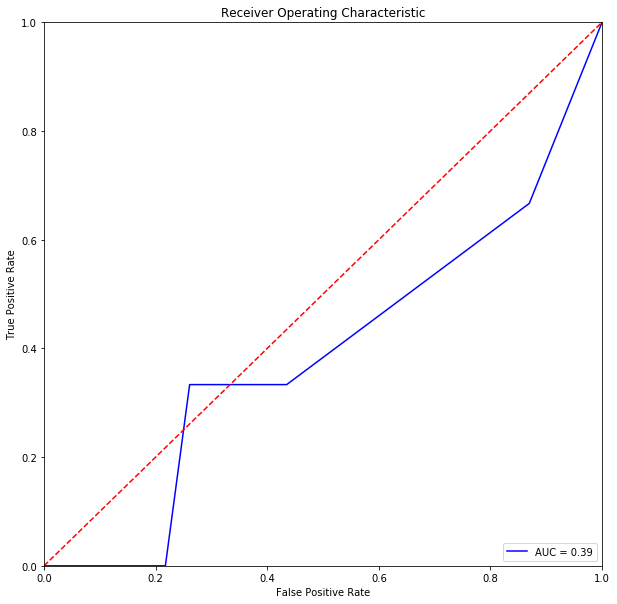

f1=0.000 auc=0.088 ap=0.116


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


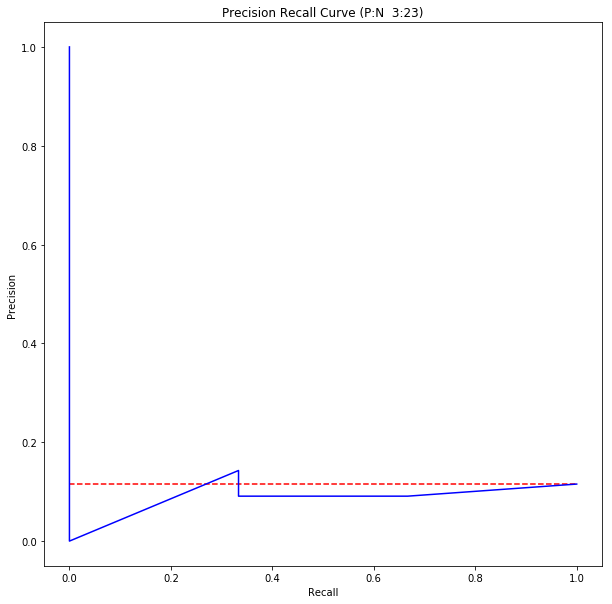

The result with the testing data is: 0.8846153846153846
AS zone.
The TP value is: 0.6363636363636364
[0.66666667 0.66666667 0.66666667 0.33333333 0.66666667 0.66666667
 0.5        0.        ]
Accuracy: 0.52 (+/- 0.45)


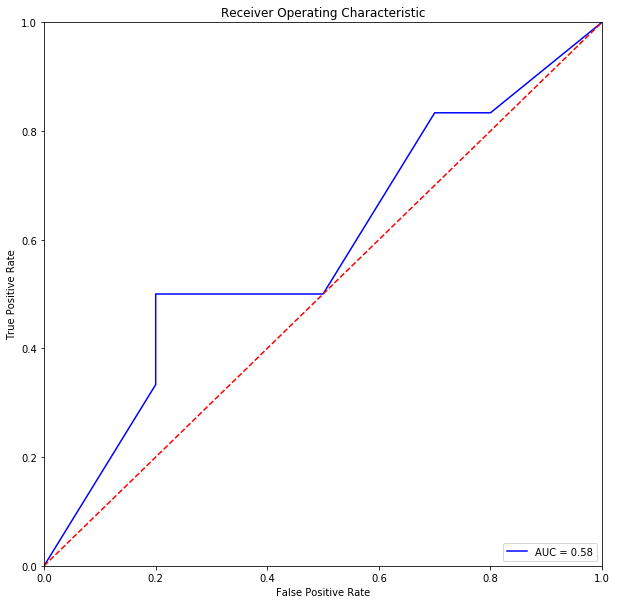

f1=0.500 auc=0.496 ap=0.465


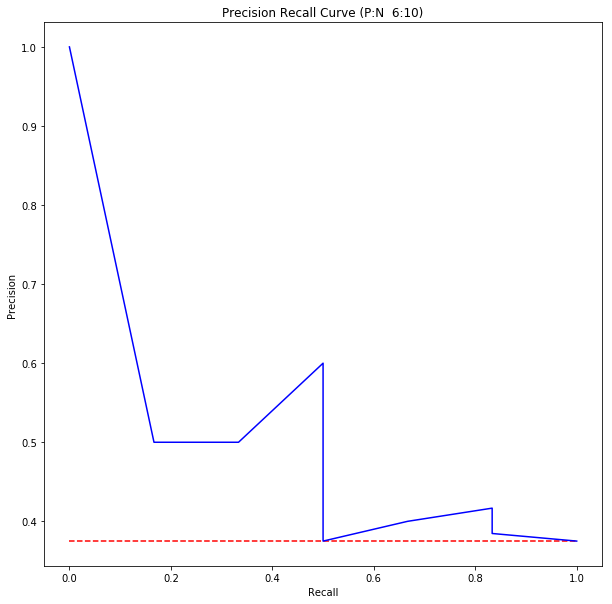

The result with the testing data is: 0.5
All the zones.
The TP value is: 0.21875
[0.80952381 0.71428571 0.76190476 0.8        0.8        0.73684211
 0.78947368 0.68421053]
Accuracy: 0.76 (+/- 0.09)


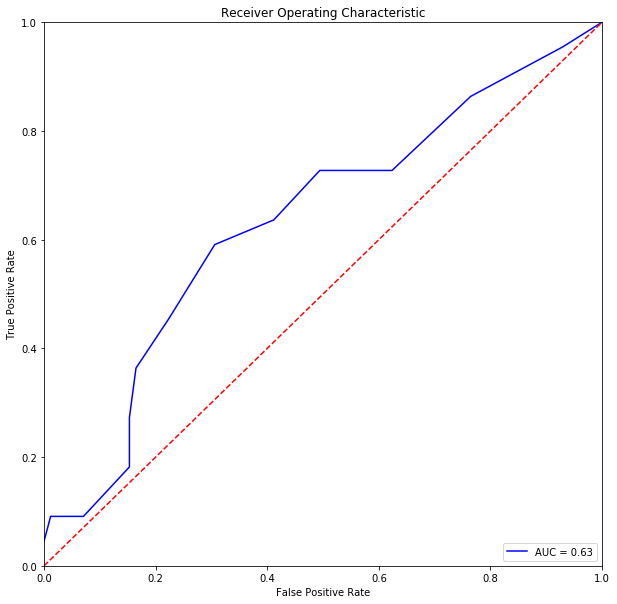

f1=0.133 auc=0.340 ap=0.333


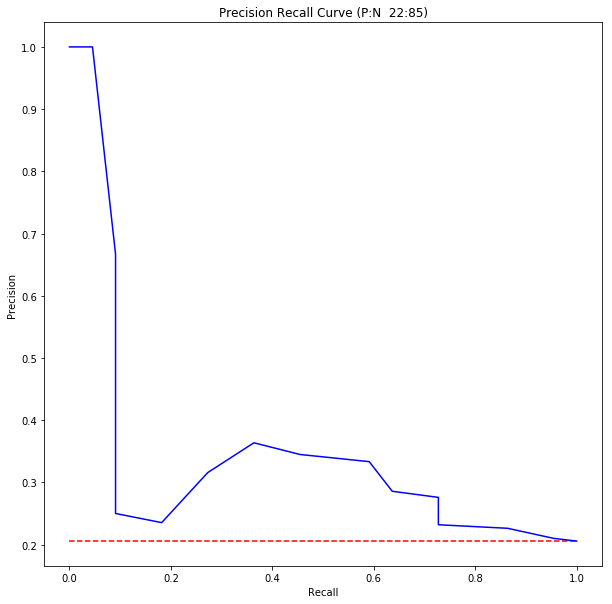

The result with the testing data is: 0.7570093457943925


In [160]:
from sklearn.model_selection import train_test_split
results = []
n_estimators = 20
print("This is an experimnent with the DWI-ADC images")
print("Random Forest 20")
print("PZ zone.")

dataframe = dyndist_adc_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "PZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("TZ zone.")
dataframe = dyndist_adc_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "TZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
dataframe = dyndist_adc_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "AS"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")
dataframe = dyndist_adc_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

K Nearest Neighbors 10
PZ zone.
The TP value is: 0.1717171717171717
[0.78571429 0.84615385 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333]
Accuracy: 0.83 (+/- 0.03)


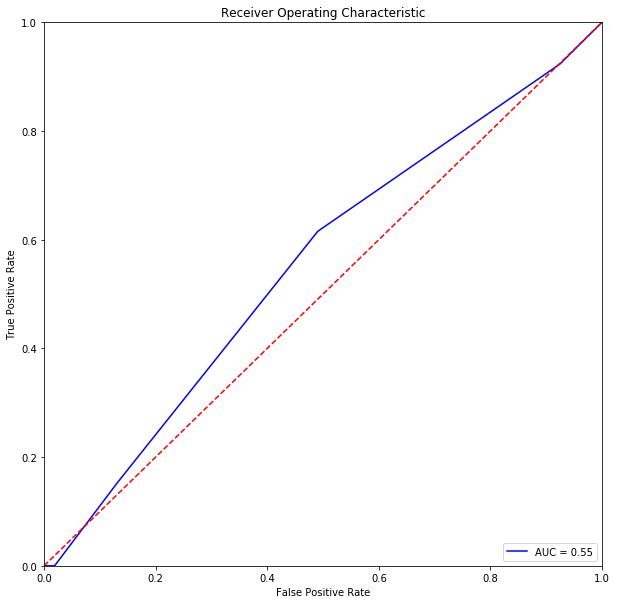

f1=0.000 auc=0.204 ap=0.218


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


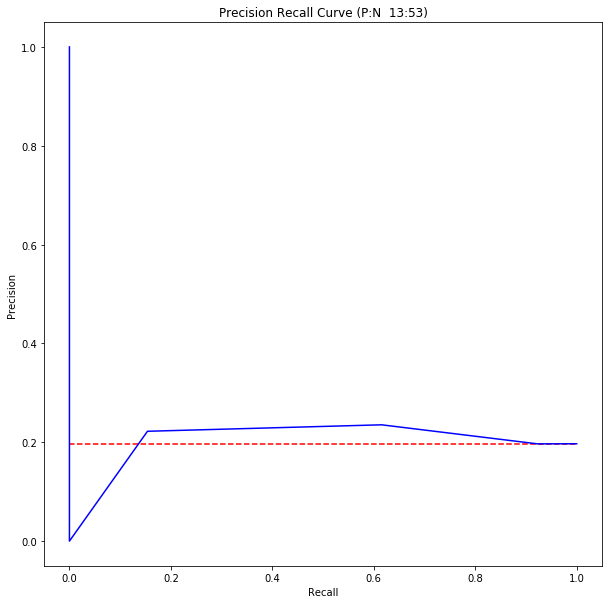

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


The result with the testing data is: 0.803030303030303
TZ zone.
The TP value is: 0.10526315789473684
[0.83333333 0.83333333 0.8        0.8        1.         1.
 1.         1.        ]
Accuracy: 0.91 (+/- 0.18)


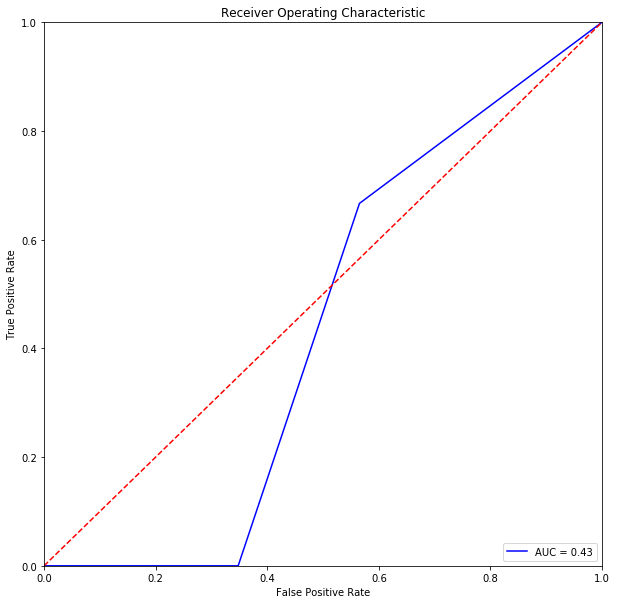

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1=0.000 auc=0.086 ap=0.127


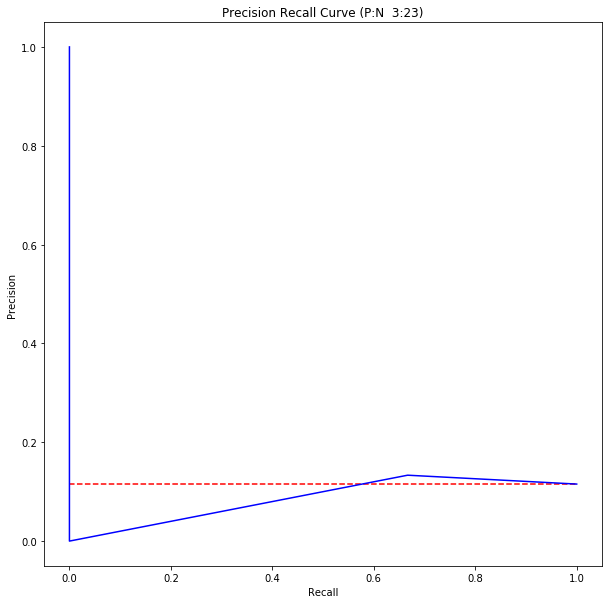

The result with the testing data is: 0.8846153846153846
AS zone.
The TP value is: 0.6363636363636364
[1.         0.33333333 0.33333333 0.33333333 0.66666667 0.33333333
 0.5        0.        ]
Accuracy: 0.44 (+/- 0.55)


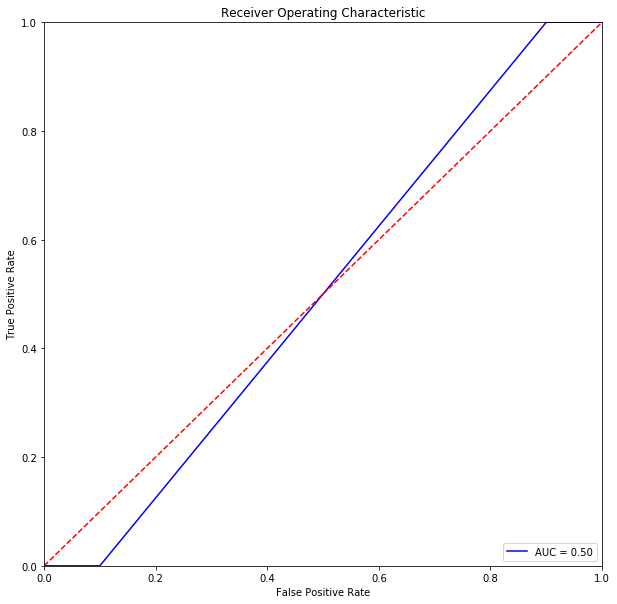

f1=0.429 auc=0.287 ap=0.388


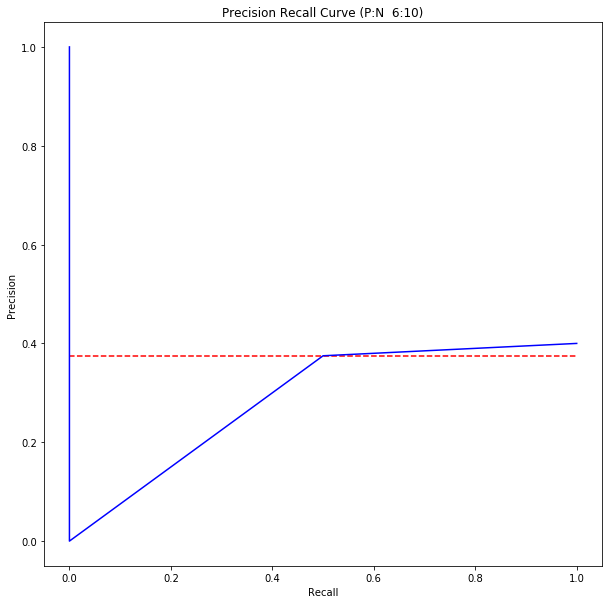

The result with the testing data is: 0.5
All the zones.
The TP value is: 0.21875
[0.71428571 0.76190476 0.80952381 0.8        0.8        0.78947368
 0.78947368 0.78947368]
Accuracy: 0.78 (+/- 0.06)


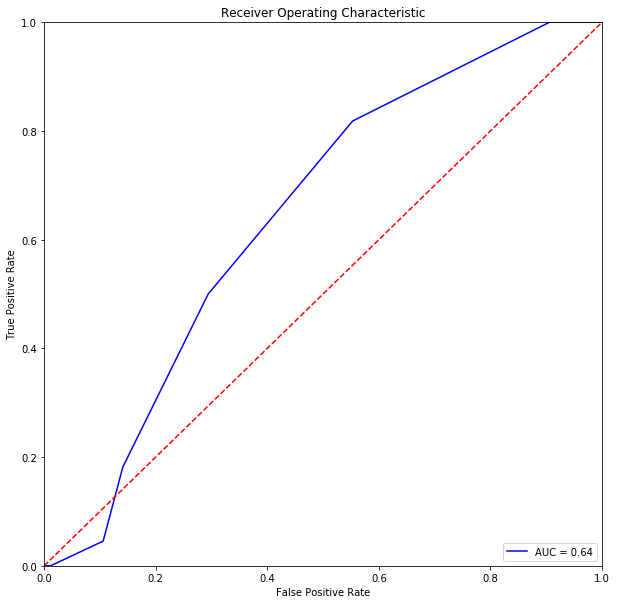

f1=0.000 auc=0.253 ap=0.264


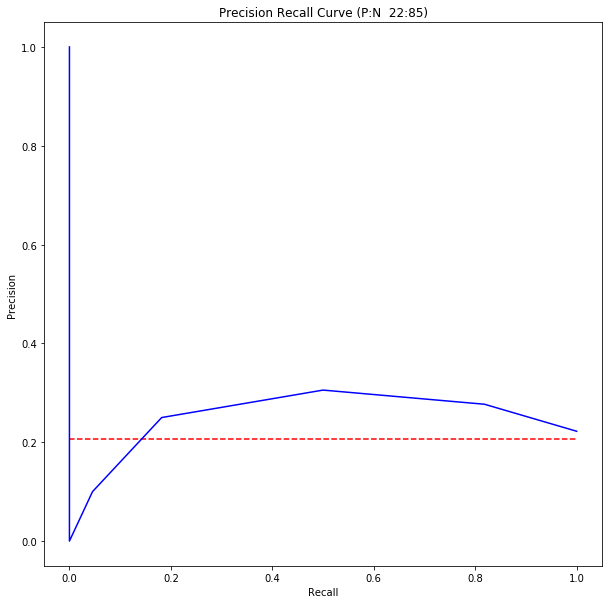

The result with the testing data is: 0.7850467289719626


In [161]:
n_neighbors=10
print("K Nearest Neighbors 10")
print("PZ zone.")
dataframe = dyndist_adc_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "PZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
print("TZ zone.")
dataframe = dyndist_adc_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "TZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")

dataframe = dyndist_adc_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "AS"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")

dataframe = dyndist_adc_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

SVM optimized PZ
PZ zone.
The TP value is: 0.1717171717171717
[0.78571429 0.84615385 0.83333333 0.83333333 0.83333333 0.83333333
 0.83333333 0.83333333]
Accuracy: 0.83 (+/- 0.03)


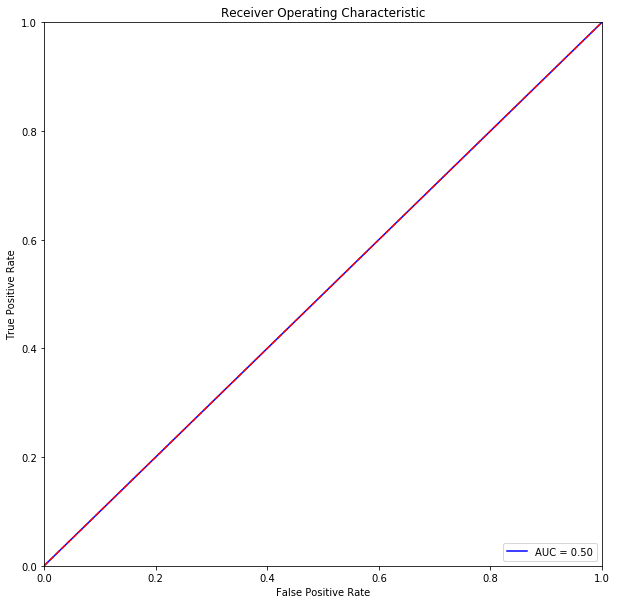

f1=0.000 auc=0.598 ap=0.197


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


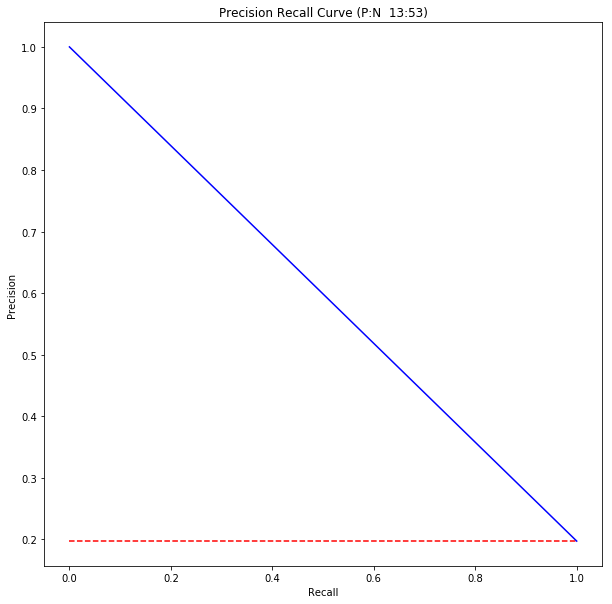

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


The result with the testing data is: 0.803030303030303
TZ zone.
The TP value is: 0.10526315789473684
[0.83333333 0.83333333 0.8        0.8        1.         1.
 1.         1.        ]
Accuracy: 0.91 (+/- 0.18)


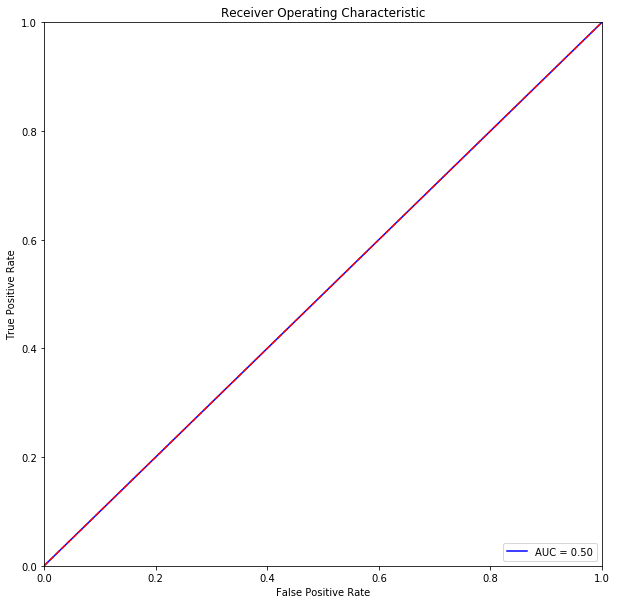

f1=0.000 auc=0.558 ap=0.115


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


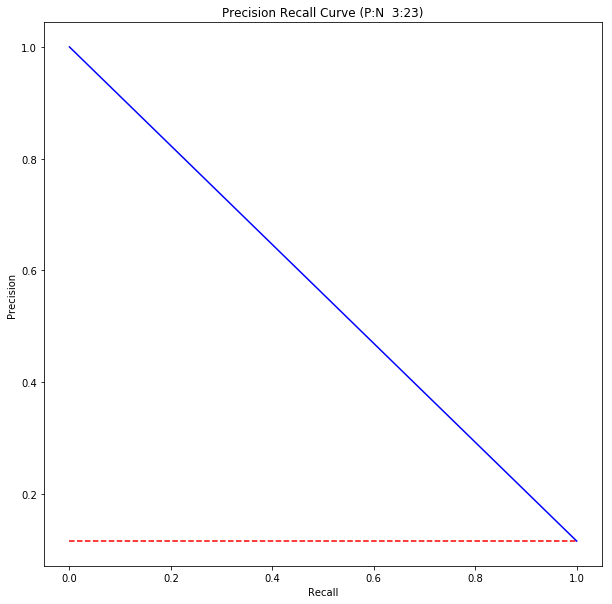

The result with the testing data is: 0.8846153846153846
AS zone.
The TP value is: 0.6363636363636364
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.5        0.5       ]
Accuracy: 0.62 (+/- 0.14)


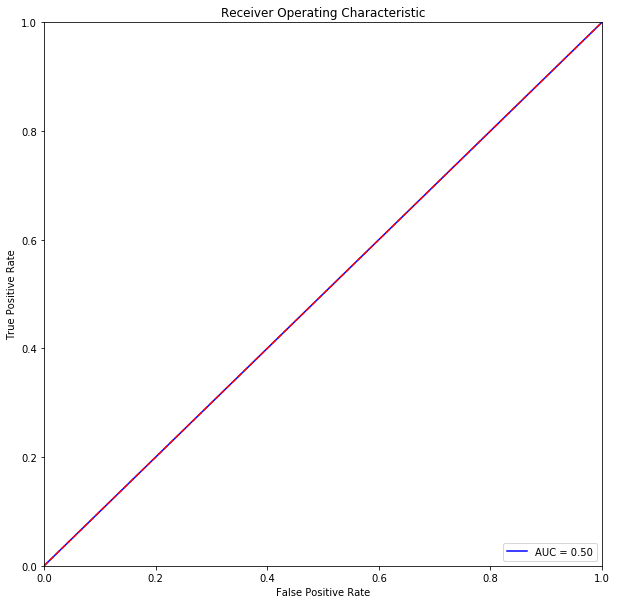

f1=0.545 auc=0.688 ap=0.375


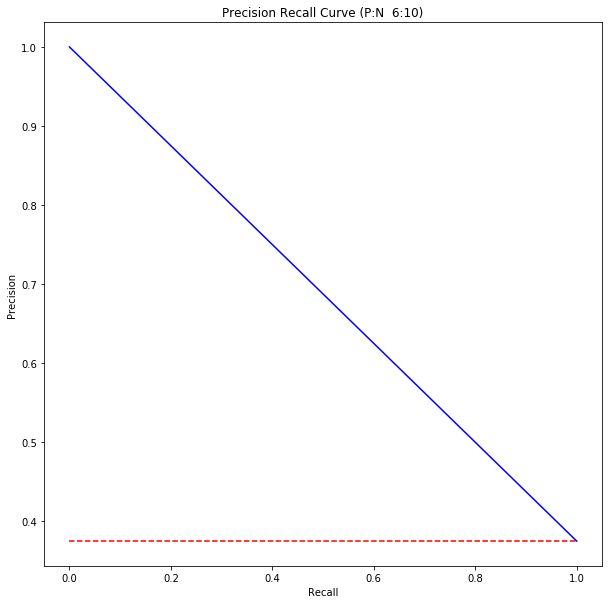

The result with the testing data is: 0.375
All the zones.
The TP value is: 0.21875
[0.76190476 0.76190476 0.76190476 0.8        0.8        0.78947368
 0.78947368 0.78947368]
Accuracy: 0.78 (+/- 0.03)


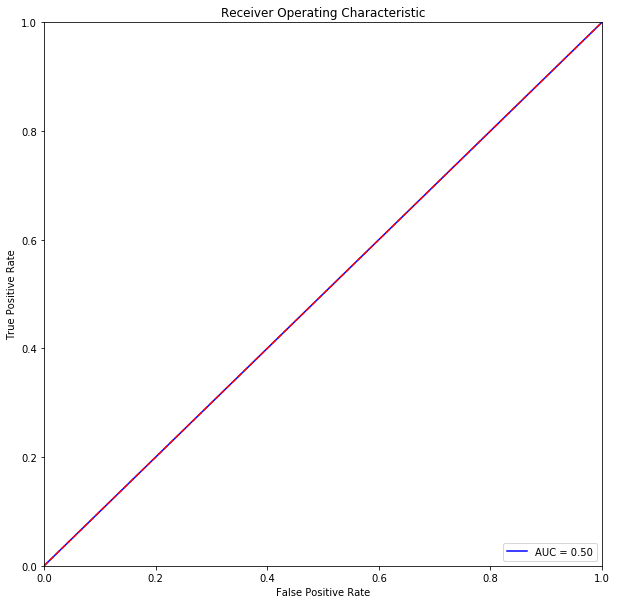

f1=0.000 auc=0.603 ap=0.206


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


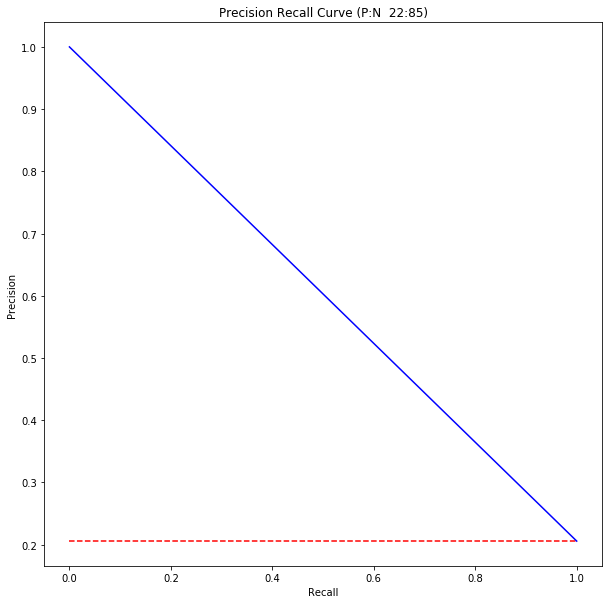

The result with the testing data is: 0.794392523364486


In [162]:
c_PZ = 0.03125 ; gamma_PZ =0.0078125 ; kernel_PZ = "rbf" ;
print("SVM optimized PZ")
print("PZ zone.")
dataframe = dyndist_adc_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_PZ = svm.SVC(kernel=kernel_PZ, gamma = gamma_PZ, C = c_PZ, probability=True, class_weight={0:1,1:(1+TP)})
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_PZ, kfolds)
results.append(["SVM optimized PZ",experiments, mean, std , "PZ"])
classifier_PZ.fit(data_train,labels_train)
classifier = classifier_PZ
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_PZ.score(data_test,labels_test)))
print("=========================================================")

print("TZ zone.")
c_TZ = 0.03125 ; gamma_TZ = 0.0078125 ; kernel_TZ = "rbf";
dataframe = dyndist_adc_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_TZ = svm.SVC(kernel=kernel_TZ, gamma = gamma_TZ, C = c_TZ, probability=True, class_weight={0:1, 1:(1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_TZ, kfolds)
results.append(["SVM optimized TZ",experiments, mean, std , "TZ"])
classifier_TZ.fit(data_train,labels_train)
classifier = classifier_TZ
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_TZ.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
c_AS = 2 ; gamma_AS = 0.0078125 ; kernel_AS = "rbf"
dataframe = dyndist_adc_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_AS = svm.SVC(kernel=kernel_AS, gamma = gamma_AS, C = c_AS, probability=True, class_weight={0:1 , 1:(1+TP) })
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_AS , kfolds)
results.append(["SVM optimized AS",experiments, mean, std , "AS"])
classifier_AS.fit(data_train,labels_train)
classifier = classifier_AS
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_AS.score(data_test,labels_test)))
print("=========================================================")

print("All the zones.")
C = 8.0 ; gamma = 0.0001220703125 ; kernel = "rbf"
dataframe = dyndist_adc_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_ALL = svm.SVC(kernel = kernel, gamma = gamma, C = C, probability=True, class_weight={0:1, 1:(1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_ALL, kfolds)
results.append(["SVM optimized ALL",experiments, mean, std , "All zones"])
classifier_ALL.fit(data_train,labels_train)
classifier = classifier_ALL
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_ALL.score(data_test,labels_test)))
print("=========================================================")

In [163]:
results_dataframe = pd.DataFrame(data= results, columns=["Classifier", "Scores", "Scores's mean %", "Scores's std %",'Zone'])
display(results_dataframe)

,Classifier,Scores,Scores's mean %,Scores's std %,Zone
0,Random Forest 20,"[0.7857142857142857, 0.8461538461538461, 0.833...",82.898352,1.688406,PZ
1,Random Forest 20,"[0.8333333333333334, 0.8333333333333334, 0.8, ...",90.833333,9.242114,TZ
2,Random Forest 20,"[0.6666666666666666, 0.6666666666666666, 0.666...",52.083333,22.726484,AS
3,Random Forest 20,"[0.8095238095238095, 0.7142857142857143, 0.761...",76.203008,4.310176,All zones
4,K Nearest Neighbors 20,"[0.7857142857142857, 0.8461538461538461, 0.833...",82.898352,1.688406,PZ
5,K Nearest Neighbors 20,"[0.8333333333333334, 0.8333333333333334, 0.8, ...",90.833333,9.242114,TZ
6,K Nearest Neighbors 20,"[1.0, 0.3333333333333333, 0.3333333333333333, ...",43.750000,27.559909,AS
7,K Nearest Neighbors 20,"[0.7142857142857143, 0.7619047619047619, 0.809...",78.176692,2.863943,All zones
8,SVM optimized PZ,"[0.7857142857142857, 0.8461538461538461, 0.833...",82.898352,1.688406,PZ
9,SVM optimized TZ,"[0.8333333333333334, 0.8333333333333334, 0.8, ...",90.833333,9.242114,TZ


# T2_TRE_SAG images experiment

In [164]:
t2_tse_sag_dataframe_at_PZ = get_dataframe_given_zone("PZ", t2_tse_sag_dataframe)
t2_tse_sag_dataframe_at_AS = get_dataframe_given_zone("AS", t2_tse_sag_dataframe)
t2_tse_sag_dataframe_at_TZ = get_dataframe_given_zone("TZ", t2_tse_sag_dataframe)
t2_tse_sag_dataframe_at_SV = get_dataframe_given_zone("SV", t2_tse_sag_dataframe)

In [165]:
create_file = True

if(create_file == True):
    print("We are creating the datasets needed.")
    dataframe = t2_tse_sag_dataframe_at_PZ
    FileName= "t2_tse_sag_dataframe_at_PZ"
    create_training_file(dataframe,FileName)

    dataframe = t2_tse_sag_dataframe_at_AS
    FileName= "t2_tse_sag_dataframe_at_AS"
    create_training_file(dataframe,FileName)

    dataframe = t2_tse_sag_dataframe_at_TZ
    FileName= "t2_tse_sag_dataframe_at_TZ"
    create_training_file(dataframe,FileName)

    dataframe = t2_tse_sag_dataframe
    FileName = "t2_tse_sag_dataframe"
    create_training_file(dataframe,FileName)
else:
    print("No dataset will be created.")

We are creating the datasets needed.
The file t2_tse_sag_dataframe_at_PZ.txt was succesfully created
The file t2_tse_sag_dataframe_at_AS.txt was succesfully created
The file t2_tse_sag_dataframe_at_TZ.txt was succesfully created
The file t2_tse_sag_dataframe.txt was succesfully created


This is an experimnent with the T2_TRE_SAG images
Random Forest 20
PZ zone.
The TP value is: 0.1968503937007874
[0.64705882 0.8125     0.8125     0.8125     0.8125     0.8125
 0.8        0.8       ]
Accuracy: 0.79 (+/- 0.11)


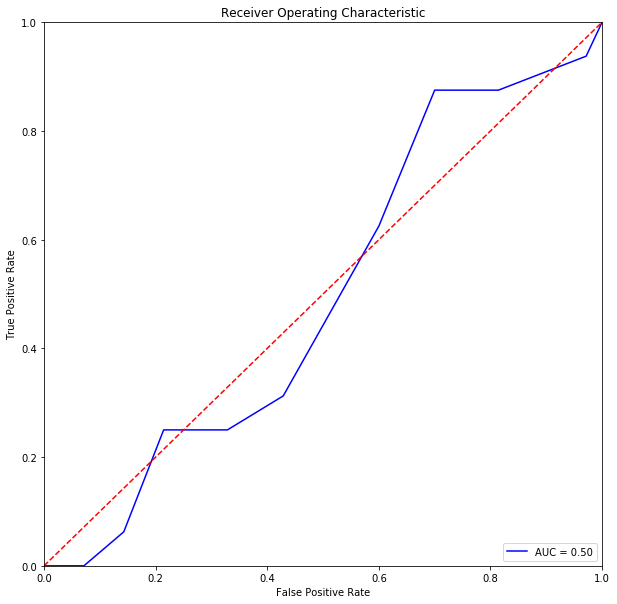

f1=0.000 auc=0.168 ap=0.193


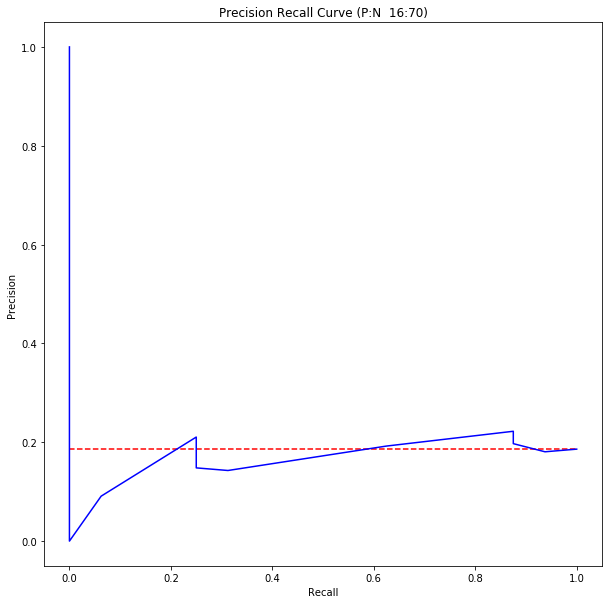

The result with the testing data is: 0.8023255813953488
TZ zone.
The TP value is: 0.07407407407407407
[0.875      0.875      0.85714286 0.85714286 1.         1.
 1.         1.        ]
Accuracy: 0.93 (+/- 0.13)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


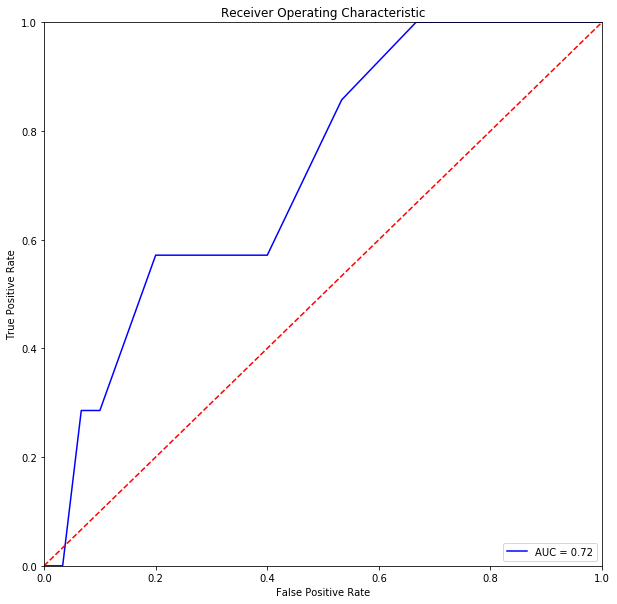

f1=0.000 auc=0.298 ap=0.372


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


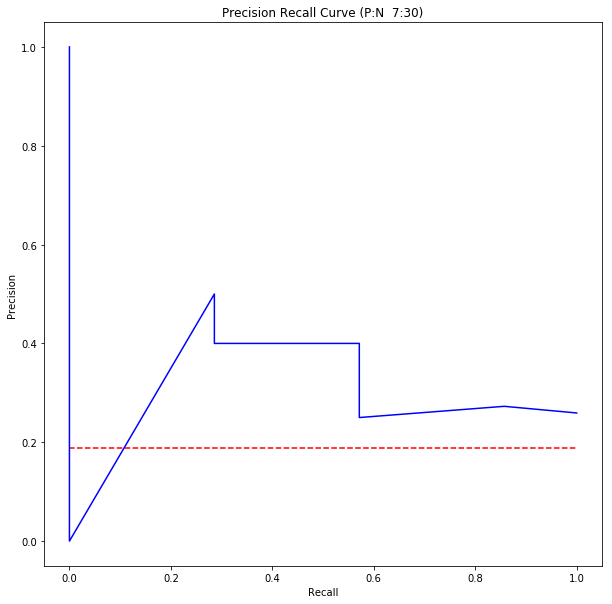

The result with the testing data is: 0.8108108108108109
AS zone.
The TP value is: 0.5588235294117647
[0.6  0.   0.4  0.5  0.25 0.25 0.5  1.  ]
Accuracy: 0.44 (+/- 0.55)


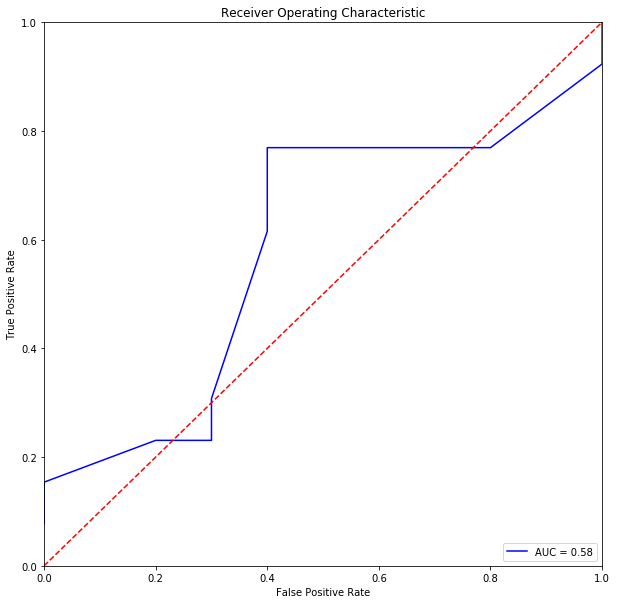

f1=0.741 auc=0.681 ap=0.686


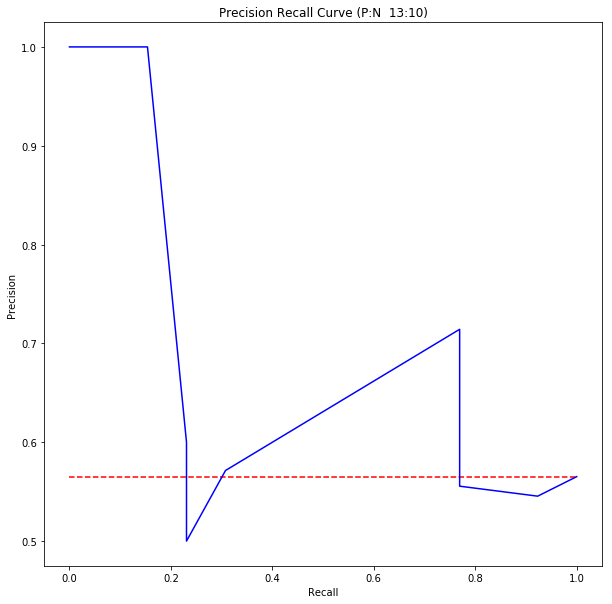

The result with the testing data is: 0.6956521739130435
All the zones.
The TP value is: 0.22580645161290322
[0.67857143 0.74074074 0.81481481 0.81481481 0.74074074 0.77777778
 0.77777778 0.74074074]
Accuracy: 0.76 (+/- 0.08)


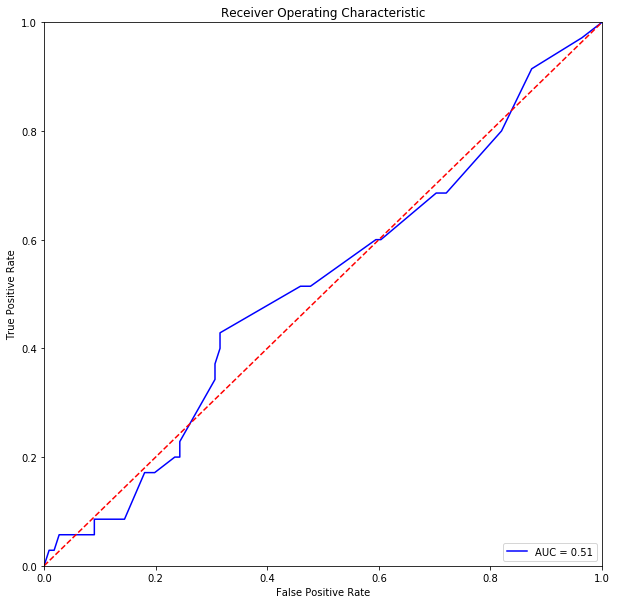

f1=0.120 auc=0.259 ap=0.258


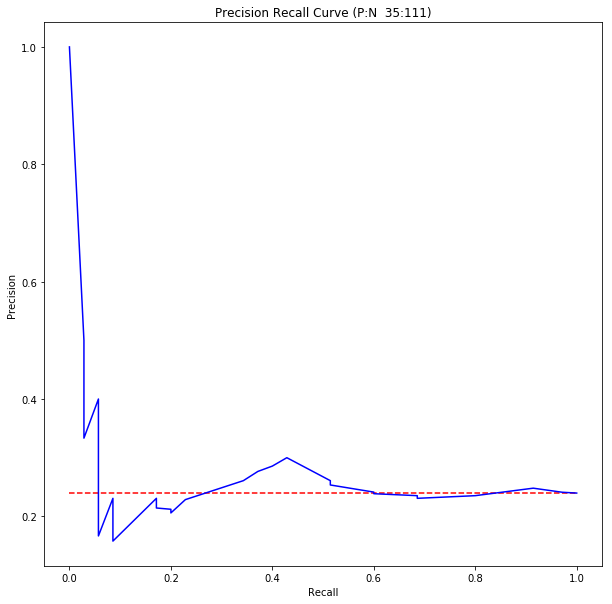

The result with the testing data is: 0.6986301369863014


In [166]:
from sklearn.model_selection import train_test_split
results = []
n_estimators = 20
print("This is an experimnent with the T2_TRE_SAG images")
print("Random Forest 20")
print("PZ zone.")

dataframe = t2_tse_sag_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "PZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("TZ zone.")
dataframe = t2_tse_sag_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "TZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
dataframe = t2_tse_sag_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "AS"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")
dataframe = t2_tse_sag_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = RandomForestClassifier(n_estimators=n_estimators, class_weight={0: 1, 1: (1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["Random Forest 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

K Nearest Neighbors 10
PZ zone.
The TP value is: 0.1968503937007874
[0.76470588 0.8125     0.8125     0.8125     0.8125     0.8125
 0.8        0.8       ]
Accuracy: 0.80 (+/- 0.03)


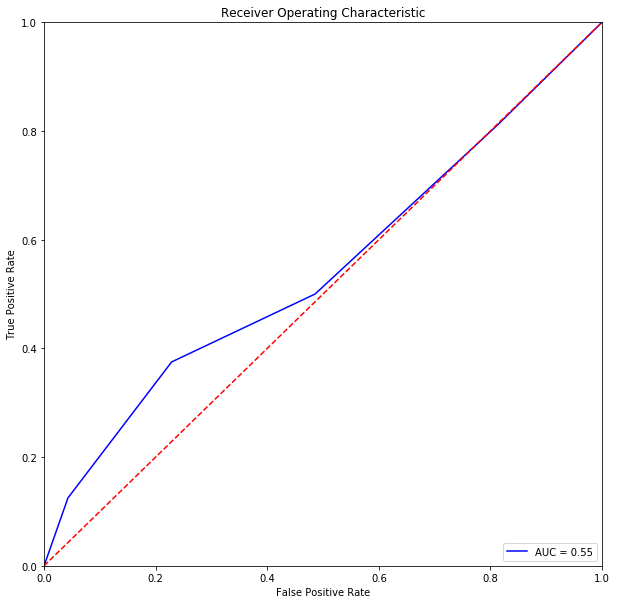

f1=0.000 auc=0.294 ap=0.235


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


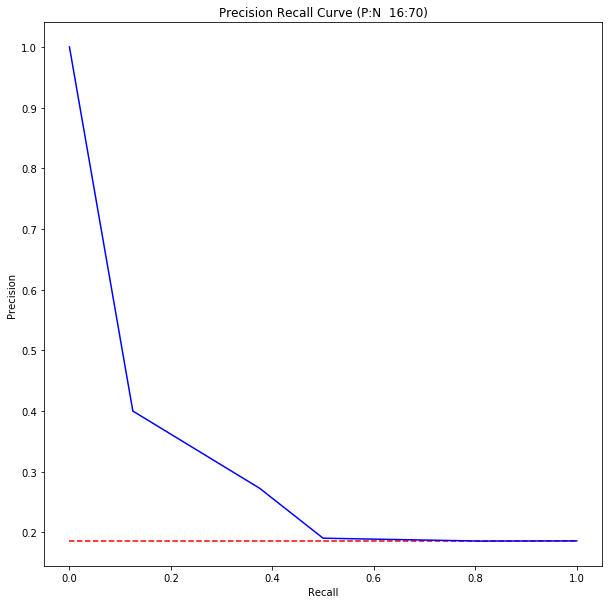

The result with the testing data is: 0.813953488372093
TZ zone.
The TP value is: 0.07407407407407407
[0.875      0.875      0.85714286 0.85714286 1.         1.
 1.         1.        ]
Accuracy: 0.93 (+/- 0.13)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


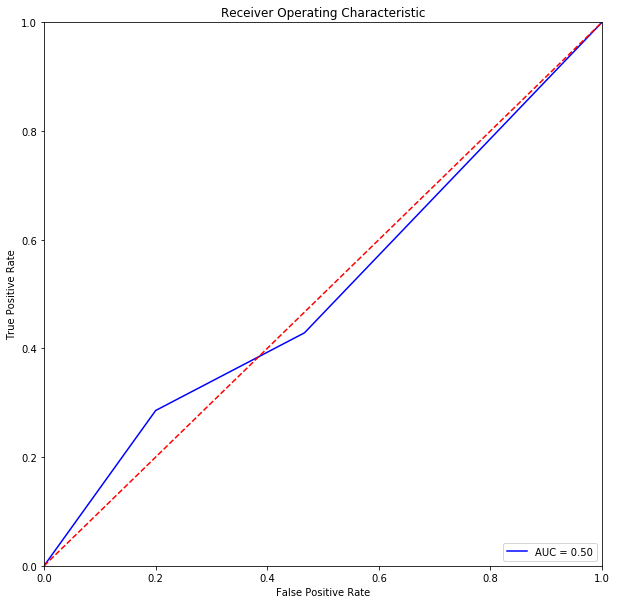

f1=0.000 auc=0.314 ap=0.205


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


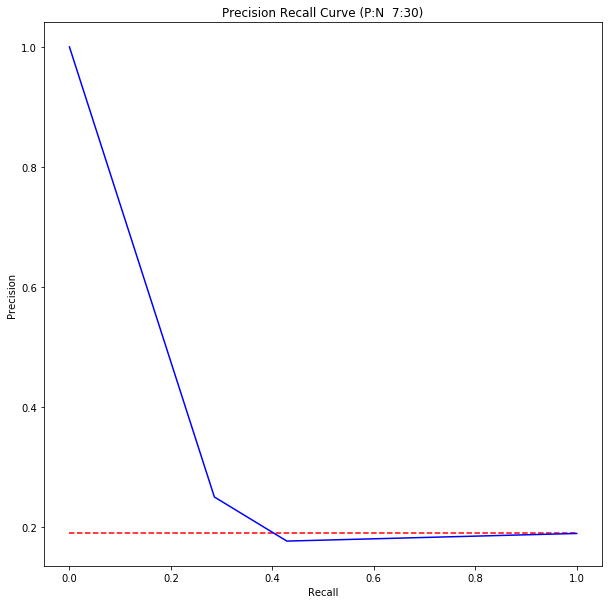

The result with the testing data is: 0.8108108108108109
AS zone.
The TP value is: 0.5588235294117647
[0.6        0.2        0.6        0.5        0.25       0.25
 1.         0.33333333]
Accuracy: 0.47 (+/- 0.50)


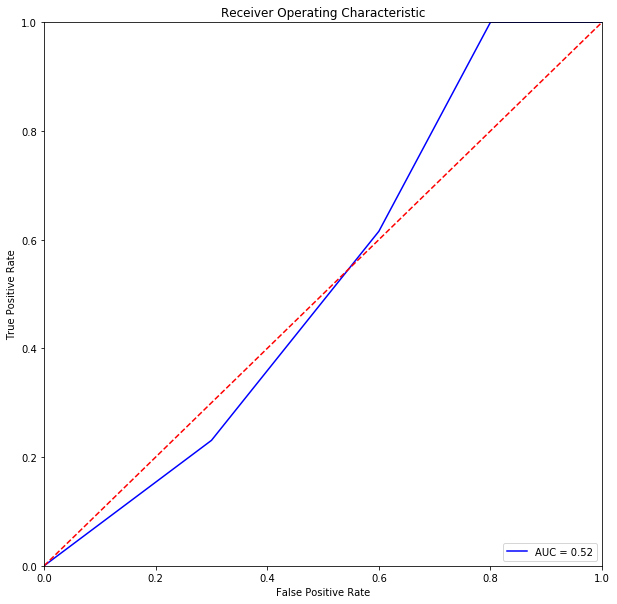

f1=0.593 auc=0.608 ap=0.573


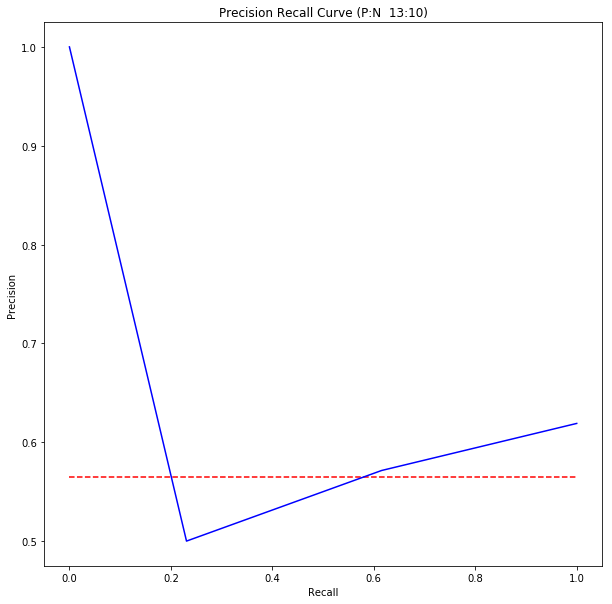

The result with the testing data is: 0.5217391304347826
All the zones.
The TP value is: 0.22580645161290322
[0.75       0.74074074 0.77777778 0.74074074 0.77777778 0.77777778
 0.77777778 0.66666667]
Accuracy: 0.75 (+/- 0.07)


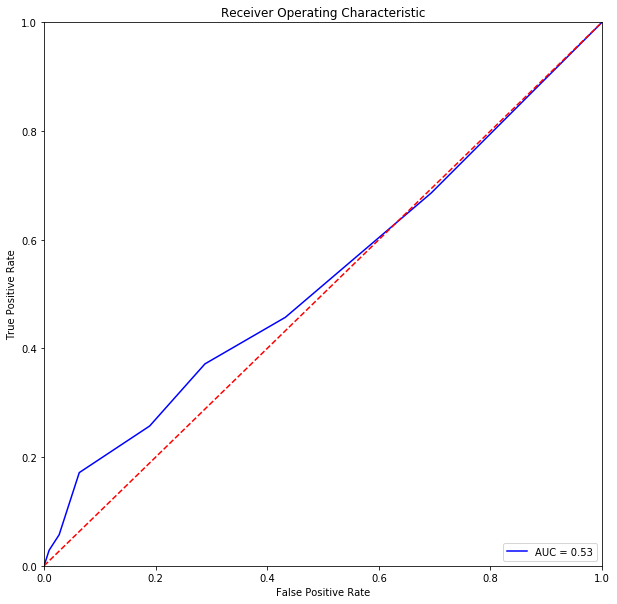

f1=0.100 auc=0.304 ap=0.288


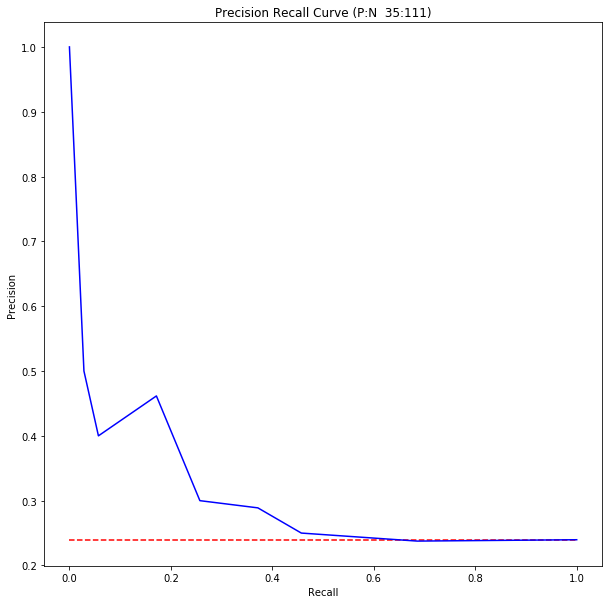

The result with the testing data is: 0.7534246575342466


In [167]:
n_neighbors=10
print("K Nearest Neighbors 10")
print("PZ zone.")
dataframe = t2_tse_sag_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "PZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
print("TZ zone.")
dataframe = t2_tse_sag_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "TZ"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")

dataframe = t2_tse_sag_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "AS"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")
      
print("All the zones.")

dataframe = t2_tse_sag_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier = neighbors.KNeighborsClassifier(n_neighbors)
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier, kfolds)
results.append(["K Nearest Neighbors 20",experiments, mean, std , "All zones"])
classifier.fit(data_train,labels_train)
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier.score(data_test,labels_test)))
print("=========================================================")

SVM optimized PZ
PZ zone.
The TP value is: 0.1968503937007874
[0.76470588 0.8125     0.8125     0.8125     0.8125     0.8125
 0.8        0.8       ]
Accuracy: 0.80 (+/- 0.03)


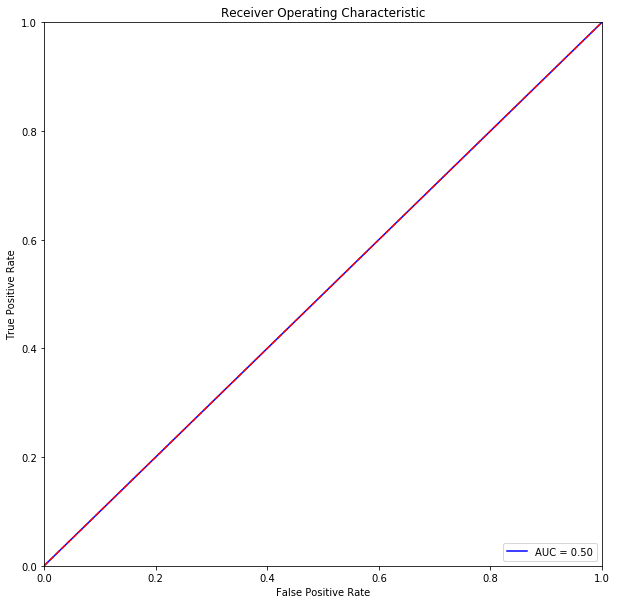

f1=0.000 auc=0.593 ap=0.186


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


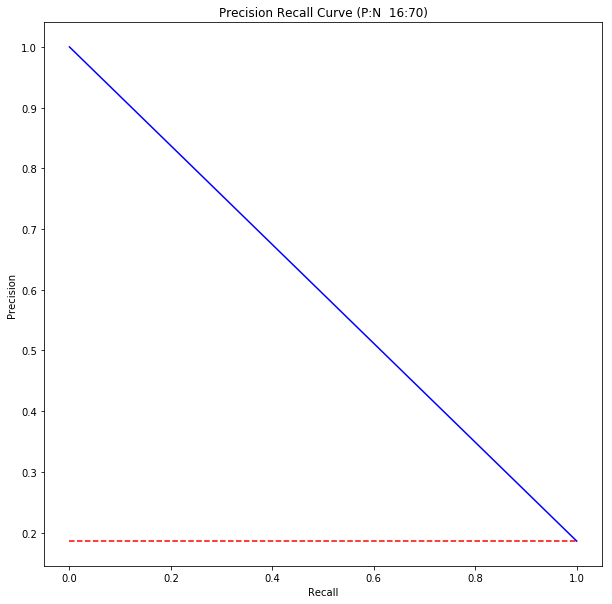

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=8.
  % (min_groups, self.n_splits)), Warning)


The result with the testing data is: 0.813953488372093
TZ zone.
The TP value is: 0.07407407407407407
[0.875      0.875      0.85714286 0.85714286 1.         1.
 1.         1.        ]
Accuracy: 0.93 (+/- 0.13)


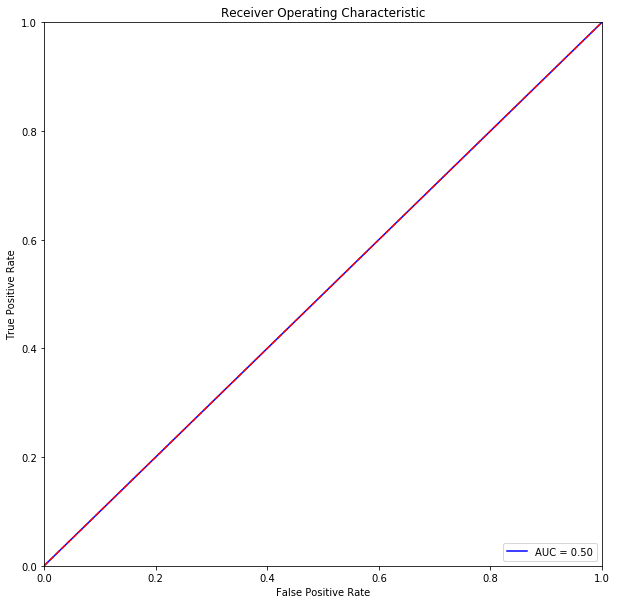

f1=0.000 auc=0.595 ap=0.189


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


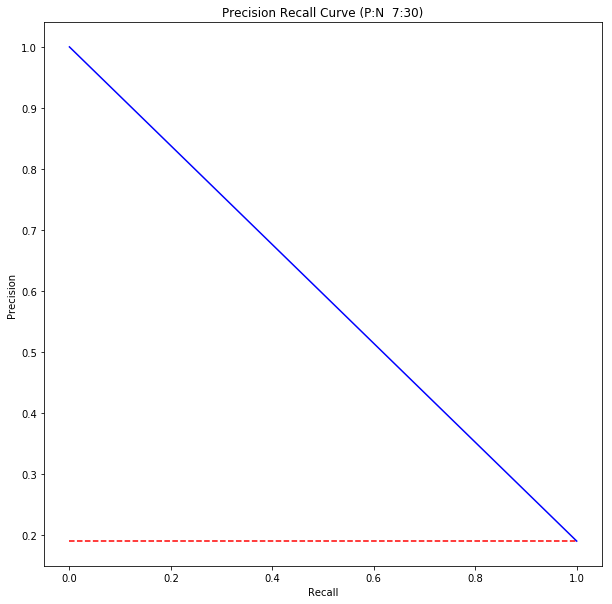

The result with the testing data is: 0.8108108108108109
AS zone.
The TP value is: 0.5588235294117647
[0.6        0.6        0.6        0.5        0.5        0.5
 0.5        0.66666667]
Accuracy: 0.56 (+/- 0.12)


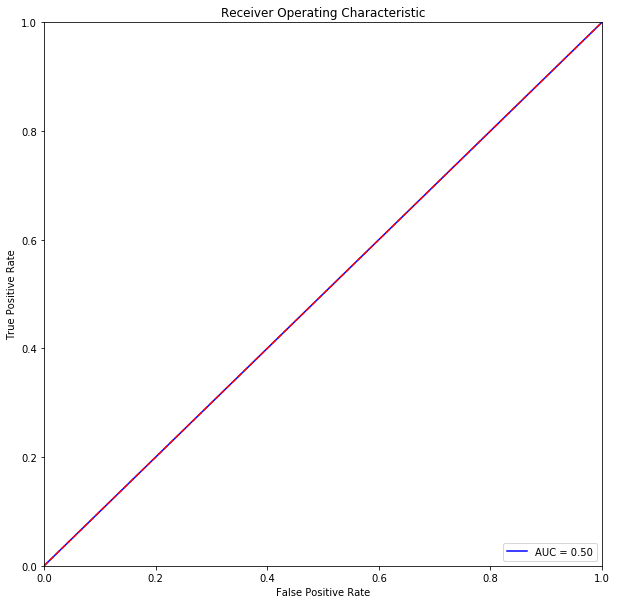

f1=0.722 auc=0.783 ap=0.565


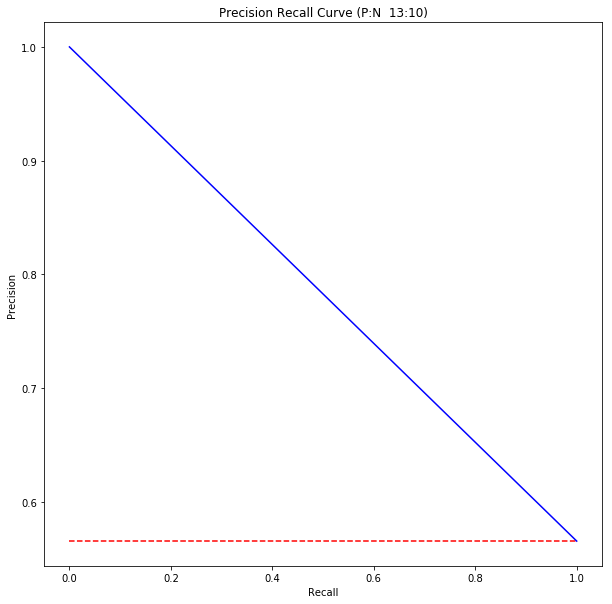

The result with the testing data is: 0.5652173913043478
All the zones.
The TP value is: 0.22580645161290322
[0.75       0.77777778 0.77777778 0.77777778 0.77777778 0.77777778
 0.77777778 0.77777778]
Accuracy: 0.77 (+/- 0.02)


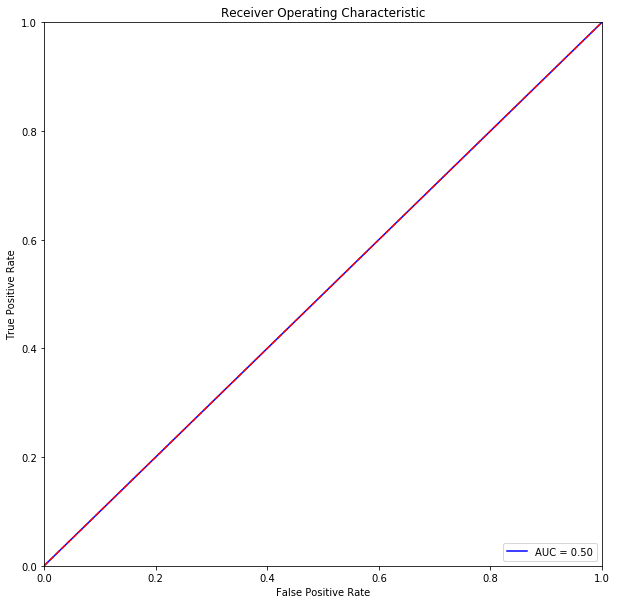

f1=0.000 auc=0.620 ap=0.240


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


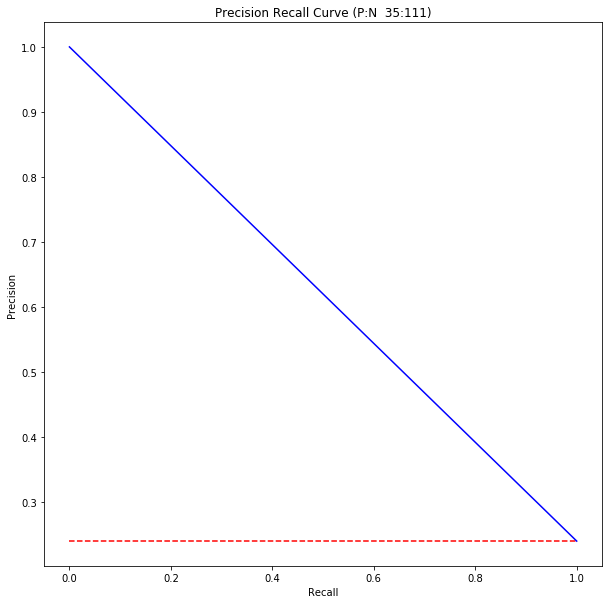

The result with the testing data is: 0.7602739726027398


In [169]:
c_PZ = 8.0 ; gamma_PZ =0.001953125 ; kernel_PZ = "rbf" ;
print("SVM optimized PZ")
print("PZ zone.")
dataframe = t2_tse_sag_dataframe_at_PZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_PZ = svm.SVC(kernel=kernel_PZ, gamma = gamma_PZ, C = c_PZ, probability=True, class_weight={0:1,1:(1+TP)})
kfolds = 8
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_PZ, kfolds)
results.append(["SVM optimized PZ",experiments, mean, std , "PZ"])
classifier_PZ.fit(data_train,labels_train)
classifier = classifier_PZ
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_PZ.score(data_test,labels_test)))
print("=========================================================")

print("TZ zone.")
c_TZ = 0.03125 ; gamma_TZ = 0.0078125 ; kernel_TZ = "rbf";
dataframe = t2_tse_sag_dataframe_at_TZ
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_TZ = svm.SVC(kernel=kernel_TZ, gamma = gamma_TZ, C = c_TZ, probability=True, class_weight={0:1, 1:(1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_TZ, kfolds)
results.append(["SVM optimized TZ",experiments, mean, std , "TZ"])
classifier_TZ.fit(data_train,labels_train)
classifier = classifier_TZ
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_TZ.score(data_test,labels_test)))
print("=========================================================")

print("AS zone.")
c_AS = 8.0 ; gamma_AS = 3.0517578125e-05 ; kernel_AS = "rbf"
dataframe = t2_tse_sag_dataframe_at_AS
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_AS = svm.SVC(kernel=kernel_AS, gamma = gamma_AS, C = c_AS, probability=True, class_weight={0:1 , 1:(1+TP) })
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_AS , kfolds)
results.append(["SVM optimized AS",experiments, mean, std , "AS"])
classifier_AS.fit(data_train,labels_train)
classifier = classifier_AS
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_AS.score(data_test,labels_test)))
print("=========================================================")

print("All the zones.")
C = 2.0 ; gamma = 0.0078125 ; kernel = "rbf"
dataframe = t2_tse_sag_dataframe
data,labels = get_data_labels(dataframe)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size = 0.4, shuffle = False)
TP = float( len(labels_train[labels_train == 1]) )/len(labels_train)
print("The TP value is: {}".format(TP))
classifier_ALL = svm.SVC(kernel = kernel, gamma = gamma, C = C, probability=True, class_weight={0:1, 1:(1+TP)})
experiments , mean, std = apply_Kfold_cross_validation(data_train, labels_train, classifier_ALL, kfolds)
results.append(["SVM optimized ALL",experiments, mean, std , "All zones"])
classifier_ALL.fit(data_train,labels_train)
classifier = classifier_ALL
plot_ROC_curve(classifier, data_test, labels_test)
plot_precision_recall_curve(classifier, data_test, labels_test)
print("The result with the testing data is: {}".format(classifier_ALL.score(data_test,labels_test)))
print("=========================================================")

In [170]:
results_dataframe = pd.DataFrame(data= results, columns=["Classifier", "Scores", "Scores's mean %", "Scores's std %",'Zone'])
display(results_dataframe)

,Classifier,Scores,Scores's mean %,Scores's std %,Zone
0,Random Forest 20,"[0.6470588235294118, 0.8125, 0.8125, 0.8125, 0...",78.869485,5.379336,PZ
1,Random Forest 20,"[0.875, 0.875, 0.8571428571428571, 0.857142857...",93.303571,6.726125,TZ
2,Random Forest 20,"[0.6, 0.0, 0.4, 0.5, 0.25, 0.25, 0.5, 1.0]",43.750000,27.698150,AS
3,Random Forest 20,"[0.6785714285714286, 0.7407407407407407, 0.814...",76.074735,4.239742,All zones
4,K Nearest Neighbors 20,"[0.7647058823529411, 0.8125, 0.8125, 0.8125, 0...",80.340074,1.554994,PZ
5,K Nearest Neighbors 20,"[0.875, 0.875, 0.8571428571428571, 0.857142857...",93.303571,6.726125,TZ
6,K Nearest Neighbors 20,"[0.6, 0.2, 0.6, 0.5, 0.25, 0.25, 1.0, 0.333333...",46.666667,25.097034,AS
7,K Nearest Neighbors 20,"[0.75, 0.7407407407407407, 0.7777777777777778,...",75.115741,3.569246,All zones
8,SVM optimized PZ,"[0.7647058823529411, 0.8125, 0.8125, 0.8125, 0...",80.340074,1.554994,PZ
9,SVM optimized TZ,"[0.875, 0.875, 0.8571428571428571, 0.857142857...",93.303571,6.726125,TZ


# t2_tse_cor images experiment

# t2_tse_tra images experiment